1. Textblob Translation

In [4]:
from textblob import TextBlob

In [7]:
def translate(text, from_l, to_l):
    en_blob = TextBlob(text)
    return en_blob.translate(from_lang=from_l, to=to_l)

translate(text='Yo estoy muy bien', from_l='es', to_l='en')

TextBlob("I'm fine")

2. Feature Extraction!

a. General and Specific Features

General features do not depend on the context or inherent meaning of the text, like word counts.
Specific features on the other hand, do.

In [8]:
#Extract general features from a text
import pandas as pd

In [9]:
df = pd.DataFrame([['The interim budget for 2019 will be announced on 1st February.'],
                   ['Do you know how much expectation the middle-class working population is having from this budget.'],
                   ['February is the shortest month in a year'],
                   ['This financial year will end on 31st March.']])

df.columns = ['text']
df.head()

,text
0,The interim budget for 2019 will be announced ...
1,Do you know how much expectation the middle-cl...
2,February is the shortest month in a year
3,This financial year will end on 31st March.


In [10]:
#Use apply() to iterate through the df rows and convert them to textblobs, extracting the words from them.
def add_num_words(df):
    df['number_of_words'] = df['text'].apply(lambda x : len(TextBlob(str(x)).words))
    return df

add_num_words(df)['number_of_words']

0    11
1    15
2     8
3     8
Name: number_of_words, dtype: int64

In [11]:
df

,text,number_of_words
0,The interim budget for 2019 will be announced ...,11
1,Do you know how much expectation the middle-cl...,15
2,February is the shortest month in a year,8
3,This financial year will end on 31st March.,8


In [15]:
def is_present(wh_words, df):
    df['is_wh_words_present'] = df['text'].apply(lambda x : True if len(set(TextBlob(str(x)).words).intersection(wh_words)) > 0 else False)
    return df

wh_words = set(['why', 'who', 'which', 'what', 'where', 'when', 'how'])

is_present(wh_words, df)['is_wh_words_present']

0    False
1     True
2    False
3    False
Name: is_wh_words_present, dtype: bool

In [22]:
df

,text,number_of_words,is_wh_words_present
0,The interim budget for 2019 will be announced ...,11,False
1,Do you know how much expectation the middle-cl...,15,True
2,February is the shortest month in a year,8,False
3,This financial year will end on 31st March.,8,False


In [26]:
#Instead of manually coding this, let's use Bag of Words (BOW) to extract features
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_text(corpus):
    """
    Will return a dataframe in which every row will be a vector representation
    of a document in a corpus
    
    ::param corpus : input text corpus
    :return: dataframe of vectors    
    """
    
    bag_of_words_model = CountVectorizer()
    
    """
    performs the following:
    1. tokenizes the collection of documents referred to as a corpus
    2. builds vocab of unique words
    3. converts a document into vectors using the vocab built in step 2
    """
    
    dense_vec_matrix = bag_of_words_model.fit_transform(corpus).todense()
    bag_of_word_df = pd.DataFrame(dense_vec_matrix)
    bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
    
    return bag_of_word_df

In [27]:
corpus = ['Data Science is an overlap between the Arts and Sciences',
          'Generally, Arts graduates are right-brained and Science graduates are left-brained',
          'Excelling in both Arts and Science at a time become difficult',
          'Natural Language Processing is part of Data Science']

df = vectorize_text(corpus)
df.head()

,an,and,are,arts,at,become,between,both,brained,data,...,natural,of,overlap,part,processing,right,science,sciences,the,time
0,1,1,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,1,1,0
1,0,1,2,1,0,0,0,0,2,0,...,0,0,0,0,0,1,1,0,0,0
2,0,1,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,1,0,1,0,0,0


In [28]:
#Create a BOW model for the top 10 most frequent terms
def bow_top_n(corpus, n):
    """
    Will return a dataframe in which every row will be represented by presence or absence of top n most
    freqeuntly occuring words in a corpus
    
    ::param corpus : input text corpus
    :return: dataframe of vectors    
    """
    
    bag_of_words_model_small = CountVectorizer(max_features=n)
     
    """
    performs the following:
    1. tokenizes the collection of documents referred to as a corpus
    2. builds vocab of unique words
    3. converts a document into vectors using the vocab built in step 2
    """
    
    bag_of_word_df_small = pd.DataFrame(bag_of_words_model_small.fit_transform(corpus).todense())
    bag_of_word_df_small.columns = sorted(bag_of_words_model_small.vocabulary_)
    
    return bag_of_word_df_small

In [29]:
df_2 = bow_top_n(corpus, 10)
df_2.head()

,and,are,arts,brained,data,graduates,is,right,science,sciences
0,1,0,1,0,1,0,1,0,1,1
1,1,2,1,2,0,2,0,1,1,0
2,1,0,1,0,0,0,0,0,1,0
3,0,0,0,0,1,0,1,0,1,0


In [33]:

import nltk

nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import string
from collections import Counter



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\telln\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def get_stop_words():
    stop_words = stopwords.words('english')
    stop_words = stop_words + list(string.printable)
    return stop_words

In [35]:
#Pull in the data and remove the stopwords
def get_and_prepare_data(stop_words):
    """
    This method will load 20newsgroups data and remove stop words from it using a given stop word list
    ::param stop_words::
    :return:
    """
    newsgroups_data_sample = fetch_20newsgroups(subset='train')
    tokenized_corpus = [word.lower() for sentence in newsgroups_data_sample['data'] for word in word_tokenize(re.sub(r'([^\s\w] |_)+', ' ',sentence))
                        if word.lower() not in stop_words]
    return tokenized_corpus

In [36]:
#Add a method to calculate the frequency of tokens
def get_frequency(corpus, n):
    token_count_di = Counter(corpus)
    return token_count_di.most_common(n)

In [37]:
#Now call all of these methods with real data and get output
stop_word_list = get_stop_words()
corpus = get_and_prepare_data(stop_word_list)
get_frequency(corpus, 50)


[('--', 109764),
 ("'ax", 61733),
 ('``', 24778),
 ("''", 20500),
 ("'s", 16430),
 ("n't", 14560),
 ('subject', 12255),
 ('lines', 11826),
 ('organization', 11194),
 ('would', 9497),
 ('one', 8802),
 ('writes', 7840),
 ('article', 6760),
 ('people', 5951),
 ('...', 5845),
 ('like', 5773),
 ('university', 5555),
 ('know', 5120),
 ('get', 4983),
 ('nntp-posting-host', 4781),
 ('max', 4703),
 ('think', 4499),
 ('also', 4301),
 ('use', 4158),
 ('new', 3934),
 ('time', 3886),
 ('could', 3869),
 ('good', 3699),
 ("'m", 3633),
 ('may', 3274),
 ('even', 3271),
 ('well', 3245),
 ('see', 3048),
 ('..', 2978),
 ('way', 2939),
 ('many', 2933),
 ('god', 2926),
 ('first', 2905),
 ('us', 2887),
 ('two', 2879),
 ('make', 2878),
 ('much', 2871),
 ('distribution', 2764),
 ('system', 2730),
 ('say', 2702),
 ('right', 2681),
 ('want', 2515),
 ('world', 2503),
 ('ca', 2481),
 ('anyone', 2464)]

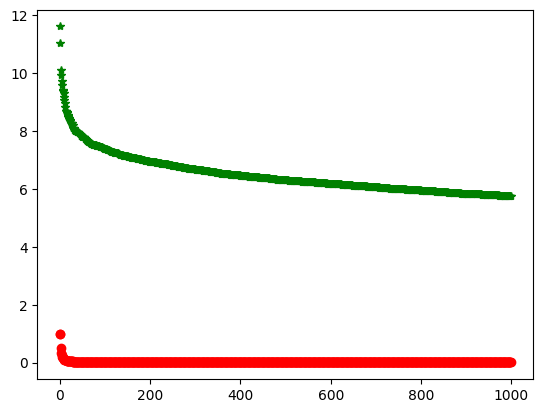

In [40]:
#Plot the rankings by frequencies - actual and expected
import math
def get_actual_and_expected_frequencies(corpus):
    freq_dict = get_frequency(corpus, 1000)
    actual_frequencies = []
    expected_frequencies = []
    for rank, tup in enumerate(freq_dict):
        actual_frequencies.append(math.log(tup[1]))
        rank = 1 if rank == 0 else rank
        #expected freq 1/rank as per Zipf's Law
        expected_frequencies.append(1/rank)
    return actual_frequencies, expected_frequencies

def plot(actual_frequencies, expected_frequencies):
    plt.plot(actual_frequencies, 'g*', expected_frequencies, 'ro')
    plt.show()

actual_frequencies, expected_frequencies = get_actual_and_expected_frequencies(corpus)
plot(actual_frequencies, expected_frequencies)

Term Frequency - Inverse Document Frequency (TFIDF)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tf_idf_vectors(corpus):
    tfidf_model = TfidfVectorizer()
    vector_list = tfidf_model.fit_transform(corpus).todense()
    return vector_list

corpus = ['Data Science is an overlap between the Arts and Sciences',
          'Generally, Arts graduates are right-brained and Science graduates are left-brained',
          'Excelling in both Arts and Science at a time become difficult',
          'Natural Language Processing is part of Data Science']

vector_list = get_tf_idf_vectors(corpus)
print(vector_list)

[[0.36935025 0.23575148 0.         0.23575148 0.         0.
  0.36935025 0.         0.         0.29119998 0.         0.
  0.         0.         0.         0.29119998 0.         0.
  0.         0.         0.36935025 0.         0.         0.
  0.19274228 0.36935025 0.36935025 0.        ]
 [0.         0.159139   0.49864399 0.159139   0.         0.
  0.         0.         0.49864399 0.         0.         0.
  0.24932199 0.49864399 0.         0.         0.         0.24932199
  0.         0.         0.         0.         0.         0.24932199
  0.13010656 0.         0.         0.        ]
 [0.         0.22444946 0.         0.22444946 0.35164346 0.35164346
  0.         0.35164346 0.         0.         0.35164346 0.35164346
  0.         0.         0.35164346 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.18350214 0.         0.         0.35164346]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.30887228 0

Text Similarity with Jaccard and Cosine Similarity

In [43]:
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity

lemmatizer = WordNetLemmatizer()

In [44]:
def extract_text_similarity_jaccard(text1, text2):
    """
    This method will return Jaccard similarity between two texts after lemmetizing them.
    :param1 text1 : text1
    :param2 text2 : text2
    :return: similarity measure 
    """
    lemmatizer = WordNetLemmatizer()
    
    words_text1 = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(text1)]
    words_text2 = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(text2)]
    
    nr = len(set(words_text1).intersection(set(words_text2)))
    dr = len(set(words_text1).union(set(words_text2)))
    
    jaccard_sim = nr/dr
    return jaccard_sim

In [45]:
#Define some text vard to test our similarity measures
pair1 = ["What you do defines you", "Your deeds define you"]
pair2 = ["Once upon a time there lived a king.", "Who is your queen?"]
pair3 = ["He is desparate", "Is he not desparate?"]

In [46]:
extract_text_similarity_jaccard(pair1[0], pair1[1])

0.14285714285714285

In [47]:
extract_text_similarity_jaccard(pair2[0], pair2[1])

0.0

In [48]:
extract_text_similarity_jaccard(pair3[0], pair3[1])

0.6

In [49]:
#Now check similarity using Cosine similarity using TFIDF. We can use the same pairs above - but need to consolidate them as 1 corpus
corpus = [pair1[0], pair1[1], pair2[0], pair2[1], pair3[0], pair3[1]]

tf_idf_vectors = get_tf_idf_vectors(corpus)

In [50]:
cosine_similarity(tf_idf_vectors[0], tf_idf_vectors[1])

C:\Users\telln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\telln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[0.3082764]])

In [51]:
cosine_similarity(tf_idf_vectors[2], tf_idf_vectors[3])

C:\Users\telln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\telln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[0.]])

In [52]:
cosine_similarity(tf_idf_vectors[3], tf_idf_vectors[4])

C:\Users\telln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\telln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[0.19989455]])

In [53]:
import numpy as np

In [57]:

def to_lower_case(corpus):
    lowercase_corpus = [x.lower() for x in corpus]
    return lowercase_corpus

def find_sentence_definition(sent_vector, definition_vectors):
        
    result_dict = []

    for definition_id, def_vector in definition_vectors.items():
        sim = cosine_similarity(sent_vector, def_vector)
        result_dict[definition_id] = sim[0][0]
        
    definition = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)[0]

    return definition[0], definition[1]

Word Clouds

In [63]:
plt.rcParams['figure.dpi'] = 200
from wordcloud import WordCloud
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [64]:
def get_data(n):
    newsgroups_data_sample = fetch_20newsgroups(subset='train')
    text = str(newsgroups_data_sample['data'][:n])
    return text

In [65]:
def load_stop_words():
    other_stopwords_to_remove = ['\\n', 'n', '\\', '>', 'nLines', 'nI',"n'"]
    stop_words = stopwords.words('english')
    stop_words.extend(other_stopwords_to_remove)
    stop_words = set(stop_words)
    return stop_words

In [66]:
def generate_word_cloud(text, stopwords):
    """
    
    This method generates word cloud object
    with given corpus, stop words and dimensions
    """
 
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    max_words=200,
                    stopwords = stopwords, 
                    min_font_size = 10).generate(text)
    return wordcloud

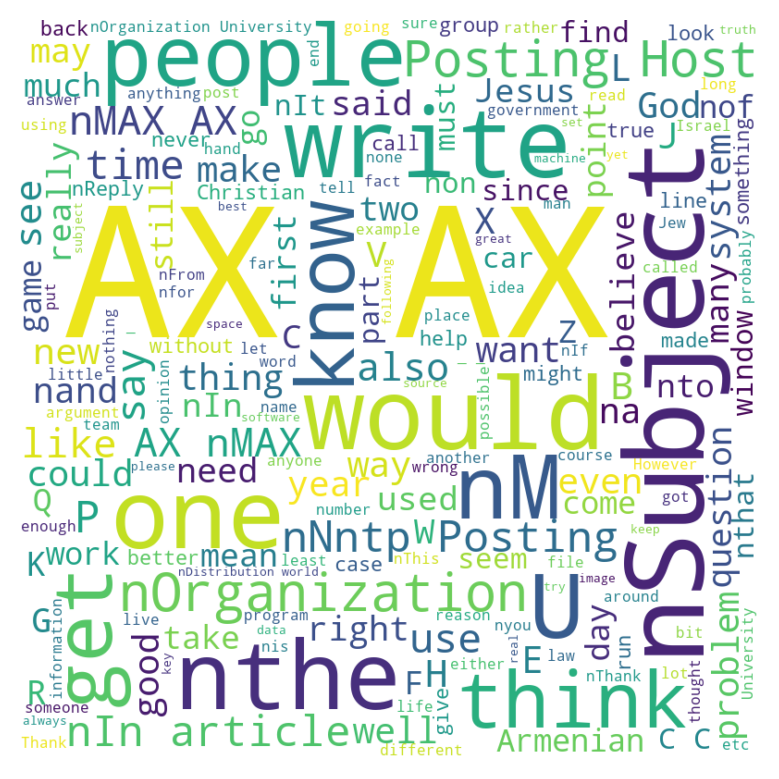

In [67]:
#Get 1000 docs, get the stop words list, generate and plot the word cloud
text = get_data(1000)
stop_words = load_stop_words()
wordcloud = generate_word_cloud(text, stop_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
import spacy
from spacy import displacy
!python -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

You should consider upgrading via the 'C:\Users\telln\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 12.8/12.8 MB 1.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [79]:
spacy.load('en_core_web_sm')

In [80]:
doc = nlp('God helps those who help themselves.')
displacy.render(doc, style='dep', jupyter=True)

In [81]:
text = 'Once upon a time there lived a saint named Ramakrishna Paramahansa. \
        His chief disciple Narendranath Dutta also known as Swami Vivekananda \
        is the founder of Ramakrishna Mission and Ramakrishna Math.'
doc2 = nlp(text)
displacy.render(doc2, style='ent', jupyter=True)